<a href="https://colab.research.google.com/github/ORIE5355/project_competition_public/blob/main/run_gym_headtohead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython import display
import itertools

%load_ext autoreload
%autoreload 2
import make_env

# Tournament Simulation

We will run a round-robin tournament, that works as follows:

- Each “round” consists of two teams competing, for `T = 2500` rounds.
- Each team will compete against every other team exactly once. And so, if there are `N` teams, then each team will compete in `N-1` rounds.
- The overall score for each team will be their overall revenue across all their games. The winner will thus be the team with the highest overall revenue across their games.

## Helpers

### Single-step

In [2]:
def run_single_step(project_part, T, headtohead):

    # Each step will be a single head-to-head competition
    assert len(headtohead) == 2

    if project_part == 1:
        env, agents = make_env.make_env_agents(agentnames = headtohead, project_part = project_part)
    else:
        env, agents = make_env.make_env_agents(agentnames = headtohead, project_part = project_part,
                                               first_file = 'data/datafile1.csv', second_file='data/datafile2.csv')
    
    # Run head-to-head
    env.reset()
    customer_covariates, sale, profits = env.get_current_state_customer_to_send_agents()
    last_customer_covariates = customer_covariates
    cumulativetimes = [0 for _ in agents]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    for t in range(0, T):
        
        actions = []
        for enoutside, agent in enumerate(agents):
            ts = time.time()
            
            action = agent.action((customer_covariates, sale, profits))
            # Have to give 1 price for each item. There is 1 item in part 1, 2 items in part 2
            assert len(action) == project_part
            
            curtime = time.time()
            cumulativetimes[enoutside] += curtime - ts
            actions.append(action)
            
        customer_covariates, sale, profits = env.step(actions)
        newplot = env.render(True)
        if newplot:
            display.clear_output(wait=True)
            
        # print('last customer covariate: ', last_customer_covariates)
        # print('last (item bought, agent bought from, prices): ', sale)
        # print('current_profit per agent: ', profits)
        last_customer_covariates = customer_covariates
    fig = plt.gcf()
    plt.close()

    return fig, env.cumulative_buyer_utility, profits, list(map(lambda x: x/T, cumulativetimes))

### Round-robin

In [3]:
def run_round_robin(project_part=1, T=500, agentnames=['dummy_rand_alpha', 'dummy_fixed_prices_adaptive']):
    """
    Simulate a round-robin dynamic pricing under competition tournament

    project_part : int
        TODO Change this for whether you're coding for part 1 or part 2!
    T : int
        Number of rounds (time-steps)
    agentnames : list(str)
        Replace the agentnames to match whatever agentfiles you create. You can use the same agentnames for both agents
    """
    results = []
    for headtohead in list(itertools.combinations(agentnames, 2)):
        
        fig, cumulative_buyer_utility, profits, avg_runtimes = run_single_step(project_part=project_part,
                                                                               T=T,
                                                                               headtohead=headtohead)
        
        results.append({'fig': fig, 'buyer_utility': cumulative_buyer_utility,
                        'agent0': headtohead[0], 'profit0': profits[0], 'avg_runtime0': avg_runtimes[0],
                        'agent1': headtohead[1], 'profit1': profits[1], 'avg_runtime1': avg_runtimes[1]})
        
    return pd.DataFrame(results).sort_values(by='buyer_utility', ascending=False).reset_index(drop=True)

## Run Competitions

In [9]:
all_agents = list(
    map(lambda x: x.replace('.py', ''), filter(lambda x: ('.py' in x) and ('__init__' not in x), os.listdir('agents/')))
)
all_agents

['ads-annihilators',
 'agent_coop_exploit_moonshot',
 'agent_coop_punish_exploit',
 'dummy',
 'dummy_fixed_prices',
 'dummy_fixed_prices_adaptive',
 'dummy_fixed_prices_adaptive_plus_rand',
 'dummy_rand_alpha',
 'dummy_xround_fp_high_alpha',
 'dummy_xround_full_price']

In [10]:
%%time
df = run_round_robin(project_part=1,
                     T=2500,
                     agentnames=all_agents)

CPU times: total: 9min 46s
Wall time: 11min 27s


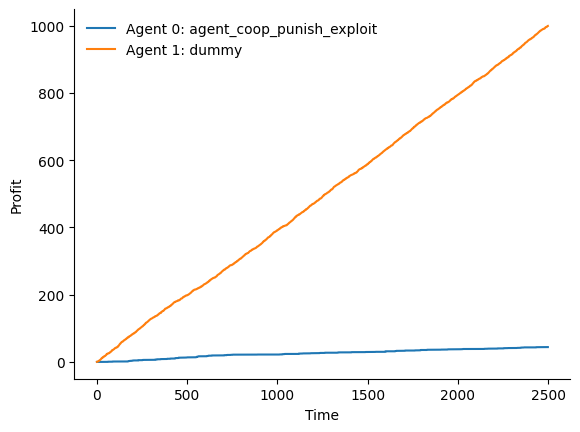

In [11]:
df.fig.iloc[0]

### Evaluation

In [12]:
ranking = pd.concat([
    df[['agent0', 'profit0']].rename(columns={'agent0': 'agent', 'profit0': 'profit'}),
    df[['agent1', 'profit1']].rename(columns={'agent1': 'agent', 'profit1': 'profit'})
]).groupby('agent').profit.sum().sort_values(ascending=False)
ranking

agent
agent_coop_exploit_moonshot              104547.270061
agent_coop_punish_exploit                 91990.303905
ads-annihilators                          90384.066662
dummy_xround_full_price                   65233.277609
dummy_fixed_prices_adaptive               64369.617666
dummy_xround_fp_high_alpha                63449.777091
dummy_fixed_prices_adaptive_plus_rand     63025.100602
dummy_fixed_prices                        48047.486033
dummy_rand_alpha                          44420.051952
dummy                                      8180.672647
Name: profit, dtype: float64